In [1]:
%matplotlib inline

In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/Stimseq


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd
import os


sc.logging.print_versions()

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-

-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                         10.0.0
anndata                     0.9.2
anyio                       NA
arrow                       1.2.3
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.12.1
backcall                    0.2.0
brotli                      1.1.0
certifi                     2023.07.22
cffi                        1.15.1
charset_normalizer          3.2.0
cloudpickle                 2.2.1
cnmf                        NA
colorama                    0.4.6
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dask                        2023.5.0
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.1.3
executing                   1.2.0
fastcluster                 1.2.6
fastjsonschema

In [4]:
! ls ../../../Data/PerDataset/Stimseq/

ADT_TP10KCLR_ForMAGIC.h5ad
count_intergenic_BRI-2248_hashing.tsv
ManualGating.Magic.20230831.tsv
ManualGating.Magic.FinalLabel.20230831.tsv
ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv
ManualGating.UnsmoothedMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv
raw.mincellfilt.htonegfilt.doubletfilt.h5ad
RNA_logTP1K_ForMAGIC.h5ad
Sorts
Stimseq_learnHarmonyRNA_RefitBoth
stimseq.pilot2.ADT.TP10K.VarNorm.leidenRNA_MI.tsv
stimseq.pilot2.ADT.VarNorm.HarmonyGeneCorrect.h5ad
stimseq.pilot2.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad
stimseq.pilot2.metadata.tsv
stimseq.pilot2.metadata.withgating.tsv
stimseq.pilot2.RNA_and_ADT.TP10K.h5ad
stimseq.pilot2.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv
stimseq.pilot2.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad
stimseq.pilot2.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu
stimseq.pilot2.RNA.HVGlist.tsv
stimseq.pilot2.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad
TCAT.20231005.tsv


In [5]:
os.path.abspath('../../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.h5ad')

'/data/srlab1/TCAT/Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.h5ad'

In [6]:
figdir = '../../../Figures/'

# Parameters

In [8]:
params = {
'harmony_vars' : ['Run', 'Biobank_ID'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 60,
'feature_type_col' : 'feature_type', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 10,
'n_rna_pcs' : 23,
'n_adt_pcs' : 21,
'name_addition' : None, # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}

if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.h5ad'
basename = 'stimseq.pilot2'
outdir = os.path.dirname(original)
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':os.path.join(outdir, basename + '.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':os.path.join(outdir, basename +  '.RNA.HVGlist.tsv'),
        'Metadata' : os.path.join(outdir, basename + '.metadata.tsv')
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = oos.path.join(outdir, basename +  '.RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = os.path.join(outdir, basename + '.ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = os.path.join(outdir, basename + '.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = os.path.join(outdir, basename + '.RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = os.path.join(outdir, basename + '.RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = os.path.join(outdir, basename + '.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = os.path.join(outdir, basename + '.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = os.path.join(outdir, basename + '.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths


{'Original': '../../../Data/PerDataset/Stimseq/raw.mincellfilt.htonegfilt.doubletfilt.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.metadata.tsv',
 'ADT_MI_Rank': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA_and_ADT.HVGlist.tsv',
 'RNA_and_ADT_Varnorm_Harmony_WNN': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu',
 'RNA_and_ADT_Varnorm_Harmony': '../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA

In [4]:
os.path.abspath('../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad')

'/data/srlab1/TCAT/Data/PerDataset/Stimseq/stimseq.pilot2.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'

In [2]:
import os
os.path.abspath('../../../Data/PerDataset/Stimseq/stimseq.pilot2.metadata.tsv')

'/data/srlab1/TCAT/Data/PerDataset/Stimseq/stimseq.pilot2.metadata.tsv'

# Run pipeline

In [6]:
adata = sc.read(paths['Original'])
for v in params['harmony_vars']:
    adata.obs[v] = adata.obs[v].astype(str)

Only considering the two last: ['.doubletfilt', '.h5ad'].
Only considering the two last: ['.doubletfilt', '.h5ad'].


In [7]:
vc = adata.var['gene_name'].astype(str).value_counts()
todrop = vc.index[vc>1]
todrop

Index(['ARMCX5-GPRASP2', 'GGT1', 'LINC01505', 'TMSB15B', 'LINC01238',
       'CYB561D2', 'MATR3', 'HSPA14', 'GOLGA8M', 'TBCE'],
      dtype='object')

In [8]:
adata = adata[:,~adata.var['gene_name'].isin(todrop)]

In [9]:
adata.var.index = adata.var['gene_name'].astype(str)


In [10]:
if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    adata_RNA.var.index = adata_RNA.var['gene_name']
    
else:
    adata_RNA = adata

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:149: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanp

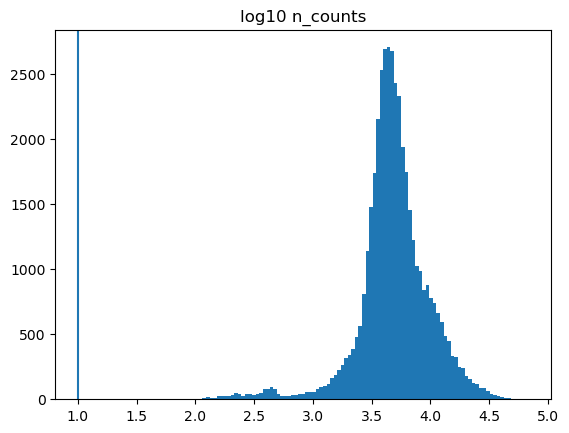

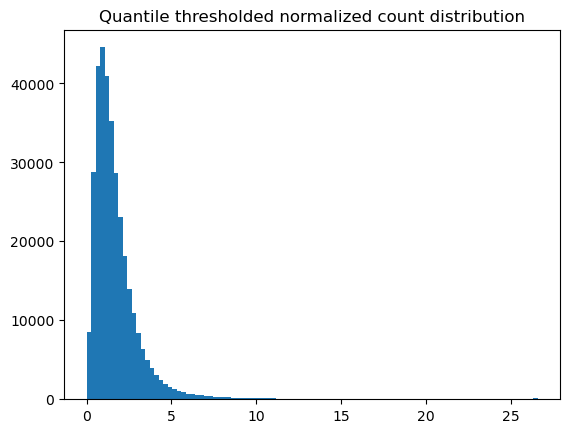

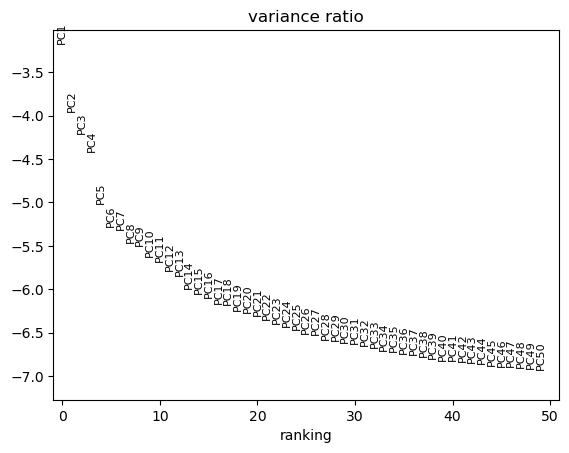

2023-09-15 08:58:46,789 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-15 08:58:58,294 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-15 08:58:58,718 - harmonypy - INFO - Iteration 1 of 20
2023-09-15 08:59:14,849 - harmonypy - INFO - Iteration 2 of 20
2023-09-15 08:59:30,571 - harmonypy - INFO - Iteration 3 of 20
2023-09-15 08:59:45,996 - harmonypy - INFO - Iteration 4 of 20
2023-09-15 09:00:01,593 - harmonypy - INFO - Iteration 5 of 20
2023-09-15 09:00:17,363 - harmonypy - INFO - Iteration 6 of 20
2023-09-15 09:00:32,792 - harmonypy - INFO - Converged after 6 iterations
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [11]:
p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'],
                           min_cells_per_gene = params['min_cells_per_RNA_gene'],
                           min_counts_per_cell = params['min_rna_counts_per_cell'],
                           filter_mito_genes = params['filter_mito_genes'],
                           filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'], n_top_rna_genes = params['n_top_rna_genes'],
                            librarysize_targetsum= 1e4, max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [12]:
adata_RNA_c.write(paths['RNA_Varnorm_Harmony'])
adata_tp10k.write(paths['RNA_and_ADT_TP10K'])


In [13]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

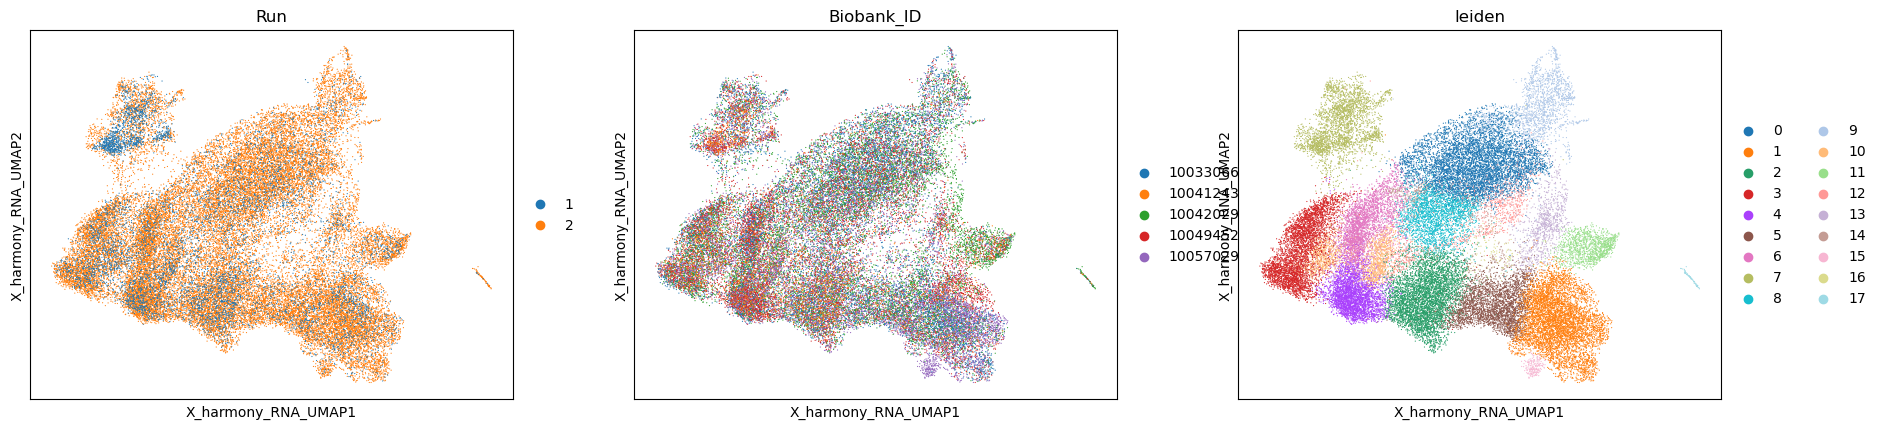

In [14]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [15]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


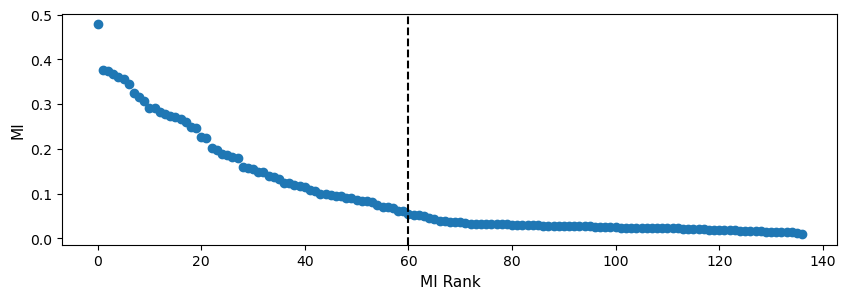

In [16]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [17]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


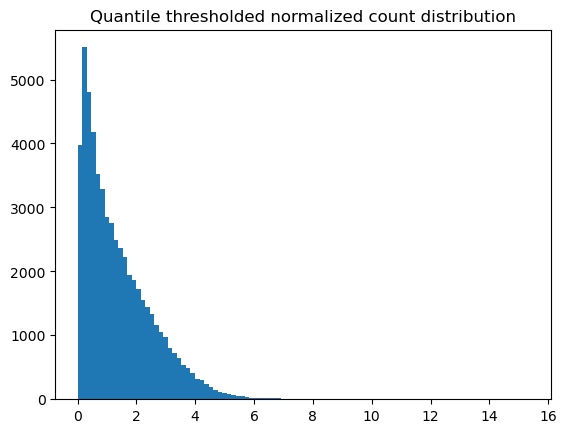

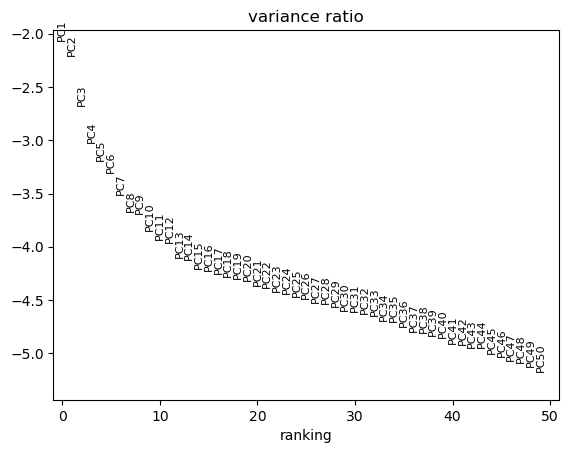

2023-09-15 09:03:45,919 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-09-15 09:03:56,858 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-09-15 09:03:57,277 - harmonypy - INFO - Iteration 1 of 20
2023-09-15 09:04:12,721 - harmonypy - INFO - Iteration 2 of 20
2023-09-15 09:04:28,137 - harmonypy - INFO - Iteration 3 of 20
2023-09-15 09:04:43,787 - harmonypy - INFO - Converged after 3 iterations


In [18]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [19]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [20]:
adata_ADT_c

AnnData object with n_obs × n_vars = 42370 × 60
    obs: 'barcode', 'BRI', 'Run', 'Well', 'Batch', 'Biobank_ID', 'Sort_Status', 'HTO_Status', 'Demuxlet_Assignment', 'Total_RNA_Count', 'Total_ADT_Count', 'Total_HTO_Count', 'frac_ADT', 'A_cdr3', 'B_cdr3', 'DEMUX_RD.UNIQ', 'DEMUX_N.SNP', 'DEMUX_BEST', 'DEMUX_SNG.1ST', 'DEMUX_SNG.LLK1', 'DEMUX_DBL.1ST', 'DEMUX_DBL.2ND', 'DEMUX_LLK12', 'DEMUX_PRB.DBL', 'DEMUX_PRB.SNG1', 'batch_name', 'B_is_cell', 'B_high_confidence', 'B_full_length', 'B_productive', 'B_length', 'B_v_gene', 'B_d_gene', 'B_j_gene', 'B_c_gene', 'B_cdr1', 'B_cdr2', 'B_cdr3_nt', 'B_reads', 'B_umis', 'B_raw_clonotype_id', 'B_raw_consensus_id', 'B_Num_Hits_In_Barcode', 'B_Next_Highest_ReadCount', 'B_Num_Productive_In_Barcode', 'B_Has_Unproductive', 'A_is_cell', 'A_high_confidence', 'A_full_length', 'A_productive', 'A_length', 'A_v_gene', 'A_d_gene', 'A_j_gene', 'A_c_gene', 'A_cdr1', 'A_cdr2', 'A_cdr3_nt', 'A_reads', 'A_umis', 'A_raw_clonotype_id', 'A_raw_consensus_id', 'A_Num_Hits

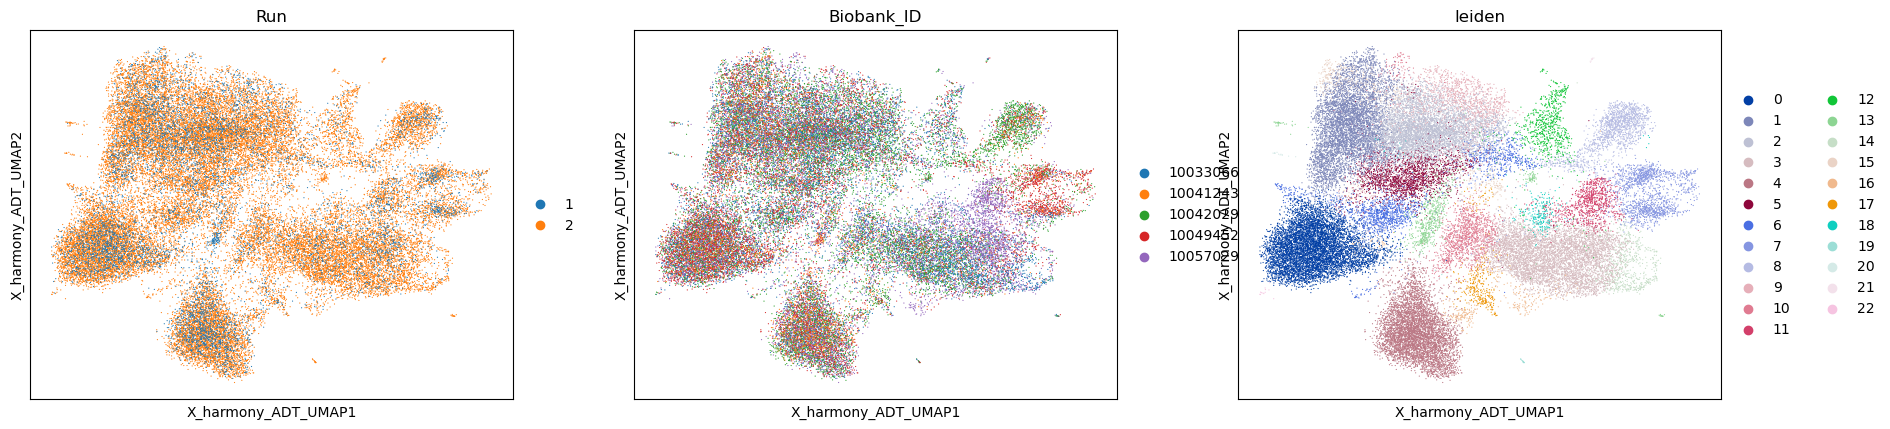

In [21]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [22]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].


In [23]:
adata_RNA_c.var

,gene_sybmol,gene_name,feature_type,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
gene_name,,,,,,,,,,,
C1orf112,ENSG00000000460,C1orf112,Gene Expression,3652,True,1476.0,0.105358,0.169739,1.300435,0.105358,0.411994
CFH,ENSG00000000971,CFH,Gene Expression,948,True,1972.0,0.027401,0.039727,1.184215,0.027401,0.199316
CYP51A1,ENSG00000001630,CYP51A1,Gene Expression,9277,True,891.0,0.370262,0.886434,1.593438,0.370262,0.941506
LAP3,ENSG00000002549,LAP3,Gene Expression,12799,True,510.0,0.725561,3.054139,2.142840,0.725561,1.747610
HS3ST1,ENSG00000002587,HS3ST1,Gene Expression,101,True,394.0,0.004059,0.012257,2.502980,0.004059,0.110710
...,...,...,...,...,...,...,...,...,...,...,...
TRBV25-1,ENSG00000282499,TRBV25-1,Gene Expression,392,True,61.0,0.057305,0.651015,9.262269,0.057305,0.806855
TRBV7-2,ENSG00000282939,TRBV7-2,Gene Expression,2526,True,23.0,0.701652,21.244391,15.674244,0.701652,4.609164
TRBV6-2,ENSG00000283063,TRBV6-2,Gene Expression,1216,True,37.0,0.245457,4.115727,12.204995,0.245457,2.028726


/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/pynndescent/pynndescent_.py:346: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/pynndescent/pynndescent_.py:348: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/pynndescent/pynndescent_.py:358: NumbaWarning: Cannot cache compiled function "process_candidates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  nn_descent_internal_low_memory_parallel(
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/pynndescent/pynndescent_.py:346: NumbaWarning: 

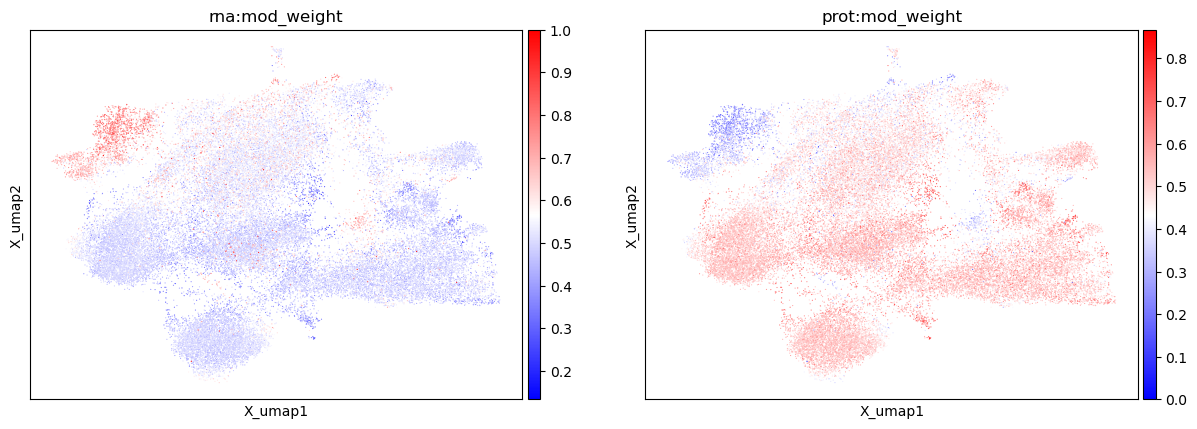

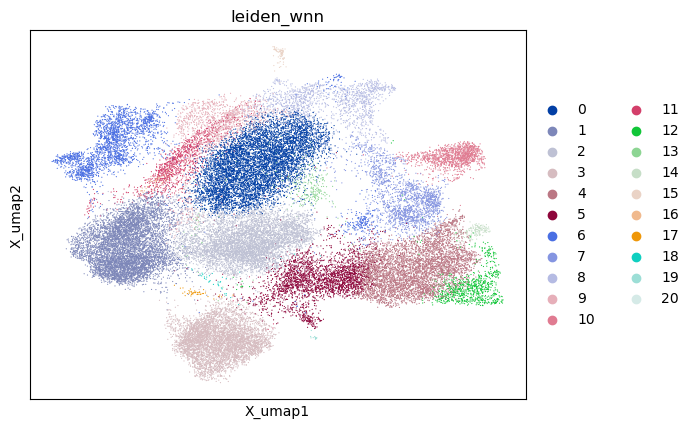

In [24]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')
mu.pl.umap(mdata, color=['leiden_wnn'])

In [25]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [26]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

In [27]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

In [28]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,B2M,PSME1,HLA-B,TMSB10,PSME2,IL32,IFITM1,ISG20,TAP1,S100A11,CFL1,TMSB4X,CISH,IRF1,STAT1,RPLP0,BST2,PFN1,GBP1,CD74
1,NOG,FHIT,ACTN1,TSHZ2,CCR7,ADTRP,PLCL1,CYSLTR1,CSGALNACT1,LINC01725,LRRN3,BNIP3,AIF1,EPHB6,IGF1R,OLFM2,AFF3,ID3,EDA,TRBV5-1
2,FTH1,SESN3,PASK,GPR183,SPON1,CRIP1,AQP3,CSGALNACT1,ITGB1,TIMP1,CCR4,SNED1,FAAH2,CYSLTR1,KRT1,ANXA1,MYO16,NEAT1,ALOX5AP,ADAM23
3,CD8B,KLRK1,ACTN1,LINC02446,LRRN3,CD8A,CCR7,KLRC4,NOG,REG4,PASK,PTPRK,AIF1,FCER1G,RUNX2,S100B,NRCAM,DBN1,RAB13,ID3
4,CCL5,CST7,NKG7,AOAH,HLA-DPB1,CD8A,KLRG1,PLEK,FGFBP2,C1orf21,ZEB2,GZMH,CMC1,EOMES,KLRK1,HLA-DPA1,KLRD1,S1PR5,PRF1,GZMA
5,KLRK1,LYAR,CD8A,CCL5,CD8B,GZMK,KLRC4,AOAH,DUSP2,METRNL,ANXA1,IGLV2-14,HLA-DPB1,FTH1,LINC01871,IFNG-AS1,CST7,PASK,YBX3,FXYD2
6,NEAT1,ARHGAP15,RUNX1,PRKCA,CDKAL1,ZNF407,BCL2,SMYD3,ANK3,IMMP2L,WWOX,CHST11,LPP,XYLT1,ETV6,RFX3,MGAT5,GMDS,MAML2,MAN1C1
7,CCL5,CST7,NKG7,TRGV9,KLRD1,TRDV2,GZMK,KLRG1,HOPX,CTSW,KLRK1,PRF1,TRDC,LINC01871,PLEK,GZMA,APOBEC3G,EFHD2,IL18RAP,PTMS
8,PKM,HSP90AB1,POLR2L,HLA-B,COX6A1,EIF4A1,MIF,PARK7,CHCHD2,RAN,ENO1,PTMA,SNRPG,H3F3B,PPIA,PSMA7,NDUFA4,NME2,COX5A,ILF2
9,FOXP3,B2M,ISG20,CISH,IL2RA,TIGIT,CD74,CMTM6,SOCS1,IL32,HLA-B,TMSB10,IFI6,TAP1,LY6E,GBP5,PSME1,TNFRSF1B,TYMP,BST2


In [29]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,CD95_or_Fas_prot,CD45RO_prot,CD274_or_B7-H1_PD-L1_prot,CD49f_prot,CD29_prot,CD26_prot,CD224_prot,CD4_prot,CD54_prot,CD134_or_OX40_prot
1,CD4_prot,CD62L_prot,TCRa_or_b_prot,CD3_prot,CD47_prot,CD7_prot,CD27_prot,CD38_prot,CD5_prot,CD45RA_prot
2,CD4_prot,CD49f_prot,CD29_prot,CD99_prot,CD5_prot,CD45RO_prot,CD47_prot,CD194_or_CCR4_prot,CD52_prot,CD48_prot
3,CD45RA_prot,CD8_prot,CD31_prot,CD73_or_Ecto-5-nucleotidase_prot,CD62L_prot,CD7_prot,CD27_prot,integrinb7_prot,CD314_or_NKG2D_prot,CD101_or_BB27_prot
4,CD11a_prot,KLRG1_or_MAFA_prot,CD244_or_2B4_prot,CD352_or_NTB-A_prot,CD18_prot,CD8_prot,CD81_or_TAPA-1_prot,TIGIT_or_VSTM3_prot,GPR56_prot,CD57Recombinant_prot
5,CD8_prot,CD99_prot,CD2_prot,CD314_or_NKG2D_prot,CD11a_prot,CD127_or_IL-7Ra_prot,CD18_prot,CD45_prot,CD48_prot,CD31_prot
6,CD274_or_B7-H1_PD-L1_prot,CD25_prot,CD95_or_Fas_prot,CD134_or_OX40_prot,CD71_prot,CD4_prot,CD54_prot,CD278_or_ICOS_prot,CD26_prot,CD45RO_prot
7,KLRG1_or_MAFA_prot,CD11a_prot,CD18_prot,TCRVd2_prot,CD195_or_CCR5_prot,CD3_prot,CD94_prot,CD244_or_2B4_prot,CD161_prot,CD99_prot
8,CD71_prot,CD54_prot,CD25_prot,CD69_prot,CD274_or_B7-H1_PD-L1_prot,CD82_prot,CD137_or_4-1BB_prot,CD18_prot,CD2_prot,CD107a_or_LAMP-1_prot
9,CD25_prot,CD95_or_Fas_prot,TIGIT_or_VSTM3_prot,CD45RO_prot,CD274_or_B7-H1_PD-L1_prot,CD49f_prot,CD54_prot,CD134_or_OX40_prot,CD194_or_CCR4_prot,CD58_or_LFA-3_prot


In [30]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

/PHShome/dk718/miniforge3/envs/cnmf_env2/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [31]:
paths['WNN_UMAP']

'../../../Data/PerDataset/Stimseq/stimseq.pilot2.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [32]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [33]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [34]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [35]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [42]:
adata_c.raw = adata[adata_c.obs.index,:]

In [43]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)

Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
Only considering the two last: ['.HarmonyGeneCorrect', '.h5ad'].
